# Kaggle: Shelter Animal Outcomes EDA and Model

Model building for Kaggle...

In [2]:
%matplotlib inline

import os
import gzip
import csv
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import re

import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

# load in the datasets to pandas
sample = pd.read_csv(u'data/sample_submission.csv.gz')
test = pd.read_csv(u'data/test.csv.gz')
train = pd.read_csv(u'data/train.csv.gz')

# adding a column to segment data after merging
test['fileName'] = 'test'
train['fileName'] = 'train'
full = pd.concat((train, test))

### Parsing out the relative ages of the animals

The age data element has values like `1 Month` or `2 Years`, in order to have an apples to apples comparison, this code converts the values to days by parsing the unit time element and converting it to a multiple (eg. 7 for week). Then it multiplies that multiple against the unit of time. For example `2 Weeks` converts to 2 * 7 or 14 days.

Finally, we convert that time to a categorical variable. If an animal is less than `1 year` old, it is considered a ***Puppy/Kitten***. Otherwise it's considered an ***Adult*** in this field.

In [3]:
full['unitOfTime'] = train.AgeuponOutcome.apply(lambda x: re.sub('s$', '', str(x).split(' ')[-1]))
full['timeVal'] = train.AgeuponOutcome.apply(lambda x: str(x).split(' ')[0])

daysMultiplier = pd.DataFrame.from_dict([{np.nan: 0, 'day' : 1, 'week' : 7, 'month' : 30, 'year' : 365}]).T.reset_index()
daysMultiplier.columns = ['unitOfTime', 'daysMultiplier']
full = pd.merge(full, daysMultiplier, on='unitOfTime', how='left', suffixes=['','_y'])
full['ageInDays'] = full['timeVal'].astype(float) * full['daysMultiplier']
full['ageGrp'] = full['ageInDays'].apply(lambda x: 'Adult' if x > 365 else 'Puppy/Kitten')

### Parsing out the sex's and neutered status

The ***Sexuponoutcome*** field has elements like `Neutered Male` or `Intact Female` are converted to Male/Female, and Neutered/Intact.

In [4]:
full['SexuponOutcome'].fillna('Unknown', inplace=True)
full['Sex'] = full['SexuponOutcome'].apply(lambda x: x.split(' ')[-1] )
full['Intactness'] = full['SexuponOutcome'].apply(lambda x: x.split(' ')[0].replace('Spayed', 'Neutered') ) 

### Parsing out the color features

In [5]:
mixColors = ['/', 'tricolor', 'calico', 'torbie', 'tabby']
def colorMixBinary(colorString):
    if any(x in colorString for x in mixColors):
        return 'mixedColor'
    else:
        return 'oneColor'

full['ColorMix'] = full['Color'].apply(lambda x: colorMixBinary(x.lower()) )

### Parsing out the breed features

Most of the breeds match up to the [List of Dogs Wikipedia](https://en.wikipedia.org/wiki/List_of_dog_breeds) table, however there were 70 or so breeds that did not have a direct one-to-one match in the dataset. 

The table below is a manual map the Austin breed names to the wikipedia breed name pages.

In [173]:
import codecs
dogMap = eval(codecs.open('data/breed_fix_dict.py', 'r', encoding='utf8').read())

dfdogMap = pd.DataFrame.from_dict(dogMap)
dfdogMap.head()

,Breed,WikiBreed
0,akita,akita inu
1,alaskan husky,alaskan klee kai
2,american eskimo,american eskimo dog
3,anatol shepherd,anatolian shepherd dog
4,bedlington terr,bedlington terrier


In [174]:
#simple parsing using pandas, but want to bring in the url for later parsing
#wikiDogBreeds = pd.read_html('https://en.wikipedia.org/wiki/List_of_dog_breeds', header=0)[0]
#wikiDogBreeds['Breed'] = wikiDogBreeds['Breed'].apply(lambda x: x.strip().lower())

from bs4 import BeautifulSoup
import requests

respond = requests.get('https://en.wikipedia.org/wiki/List_of_dog_breeds')
soup = BeautifulSoup(respond.text, "lxml")
                     
data = []
table = soup.find('table', class_='wikitable')
rows = table.find_all('tr')

headers = rows[0].find_all('th')
headerText = [header.text.strip() for header in headers]
headerText.append('wikiUrl')
for row in rows[1:-1]:  #skip the header/footer rows
    wikiUrl = row.find_all('a')[0].get('href')
    cols = row.find_all('td')
    cols = [ele.text.strip().encode('utf8') for ele in cols]
    cols.append(wikiUrl)
    data.append([ele for ele in cols])
wikiDogBreeds = pd.DataFrame(data, columns=headerText)
wikiDogBreeds.Breed = wikiDogBreeds.Breed.apply(lambda x: x.strip().lower())
del wikiDogBreeds['Image'] # no data is pulled into this column
wikiDogBreeds.columns =  ['WikiBreed', 'Origin', 'Federation Cynologique Internationale',
                          'American Kennel Club', 'Australian National Kennel Council',
                          'Canadian Kennel Club', 'The Kennel Club',u'New Zealand Kennel Club',
                          'United Kennel Club[9]', 'wikiUrl']

In [166]:
dataDogBreeds = {}
maxLen = 0
for b in full[full.AnimalType=='Dog']['Breed'].unique():
    mixNames = b.split('/')
    if maxLen < len(mixNames):
        maxLen = len(mixNames)
    for n in range(len(mixNames)):
        breed = mixNames[n].replace('Mix','').strip().lower().encode('utf8')
        if breed not in dataDogBreeds.keys():
            dataDogBreeds[breed] = 1
        else:
            dataDogBreeds[breed] = dataDogBreeds[breed]+1

dataDogBreeds = pd.DataFrame(dataDogBreeds.items(), columns=['Breed', 'Cnt'])
dataDogBreeds = pd.merge(dataDogBreeds,dfdogMap, how='left', on='Breed')
dataDogBreeds['WikiBreed'].fillna(dataDogBreeds.Breed, inplace=True)

In [110]:
print 'Count of Austin Data Dog Breeds: %d' % dataDogBreeds['Breed'].count()
print 'Count of Wiki Data Dog Breeds: %d' % wikiDogBreeds['WikiBreed'].count()

Count of Austin Data Dog Breeds: 197
Count of Wiki Data Dog Breeds: 510


In [176]:
wikiBreeds = pd.merge(dataDogBreeds, wikiDogBreeds, how='left', on='WikiBreed')
wikiBreeds[wikiBreeds.WikiBreed.str.contains('chen')]

,Breed,Cnt,WikiBreed,Origin,Federation Cynologique Internationale,American Kennel Club,Australian National Kennel Council,Canadian Kennel Club,The Kennel Club,New Zealand Kennel Club,United Kennel Club[9],wikiUrl
29,lowchen,2,löwchen,"Germany, France, Netherlands, Spain",Group 09 Section 01 #233,Non-Sporting Group,Group 01(Toys),Group 06 (Non-Sporting),Toys,Toys,Companion Dog,/wiki/L%C3%B6wchen


In [177]:
#wikiBreeds['American Kennel Club'].unique()
wikiBreeds['The Kennel Club'].unique()

array(['Working', 'Toy', 'Utility', 'Pastoral', 'Gundog', 'Gun dog', '',
       'Terrier', 'Hound', nan, 'Toys', 'Terriers', 'Sporting Dog',
       'Toy Group'], dtype=object)

In [178]:
dogs = full[full.AnimalType=='Dog'].copy()
dogs['Breed0'] = dogs.Breed.apply(lambda x: x.split('/')[0].replace('Mix',''))
dogs.head()



,AgeuponOutcome,AnimalID,AnimalType,Breed,Color,DateTime,ID,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,fileName,unitOfTime,timeVal,daysMultiplier,ageInDays,ageGrp,Sex,Intactness,ColorMix,Breed0
0,1 year,A671945,Dog,Shetland Sheepdog Mix,Brown/White,2014-02-12 18:22:00,NaN,Hambone,NaN,Return_to_owner,Neutered Male,train,year,1,365.0,365.0,Puppy/Kitten,Male,Neutered,mixedColor,Shetland Sheepdog
2,2 years,A686464,Dog,Pit Bull Mix,Blue/White,2015-01-31 12:28:00,NaN,Pearce,Foster,Adoption,Neutered Male,train,year,2,365.0,730.0,Adult,Male,Neutered,mixedColor,Pit Bull
4,2 years,A667013,Dog,Lhasa Apso/Miniature Poodle,Tan,2013-11-15 12:52:00,NaN,NaN,Partner,Transfer,Neutered Male,train,year,2,365.0,730.0,Adult,Male,Neutered,oneColor,Lhasa Apso
5,1 month,A677334,Dog,Cairn Terrier/Chihuahua Shorthair,Black/Tan,2014-04-25 13:04:00,NaN,Elsa,Partner,Transfer,Intact Female,train,month,1,30.0,30.0,Puppy/Kitten,Female,Intact,mixedColor,Cairn Terrier
8,5 months,A671784,Dog,American Pit Bull Terrier Mix,Red/White,2014-02-04 17:17:00,NaN,Lucy,NaN,Adoption,Spayed Female,train,month,5,30.0,150.0,Puppy/Kitten,Female,Neutered,mixedColor,American Pit Bull Terrier


OutcomeType  Adoption  Died  Euthanasia  Return_to_owner  Transfer
AnimalType                                                        
Cat              4272   147         710              500      5505
Dog              6497    50         845             4286      3917


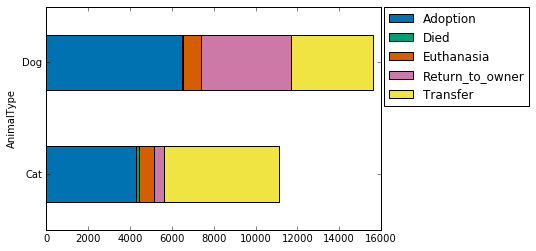

In [7]:
outcomes = train.groupby(['AnimalType', 'OutcomeType'])\
            ['AnimalID'].count().unstack()

print outcomes    
outcomes_plot = outcomes.plot.barh(stacked=True)
outcomes_plot.legend(loc=(1.01,.555), ncol=1)


In [8]:
full.timeVal.unique()

array(['1', '2', '3', '5', '4', '10', '6', '7', '12', '9', '11', '8', '15',
       '0', '14', '16', '13', 'nan', '17', '18', '19', '20'], dtype=object)

In [9]:
full['unitOfTime'].unique()

array(['year', 'week', 'month', 'day', 'nan'], dtype=object)

In [10]:
full['timeVal'].unique()

array(['1', '2', '3', '5', '4', '10', '6', '7', '12', '9', '11', '8', '15',
       '0', '14', '16', '13', 'nan', '17', '18', '19', '20'], dtype=object)

In [179]:
from bokeh.charts import Bar, TimeSeries, output_file, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [180]:
outcomes = train.groupby(['AnimalType', 'OutcomeType'])\
            ['AnimalID'].count().reset_index()
outcomes.columns = ['AnimalType', 'OutcomeType', 'num_animals']
    
hover = HoverTool(
        tooltips=[
            ("Animal", "$x"),  
            ("Outcome", "@OutcomeType"),
            ("Number", "@height{int}"),
        ]
    )
p = Bar(outcomes, label='AnimalType', values='num_animals', agg='sum',\
        stack='OutcomeType', legend='top_left', plot_height=500,\
        tools=[hover]) 
#source = ColumnDataSource(p)
show(p)

In [38]:
outcomes

,ColorMix,OutcomeType,num_animals
0,mix,Adoption,7702
1,mix,Died,135
2,mix,Euthanasia,1091
3,mix,Return_to_owner,3247
4,mix,Transfer,6590
5,single,Adoption,3067
6,single,Died,62
7,single,Euthanasia,464
8,single,Return_to_owner,1539
9,single,Transfer,2832


In [182]:
outcomes = full[full.fileName == 'train'].groupby(['ColorMix', 'OutcomeType'])\
            ['AnimalID'].count().reset_index()
outcomes.columns = ['ColorMix', 'OutcomeType', 'num_animals']
    
hover = HoverTool(
        tooltips=[
            ("Animal", "$x"),  
            ("Outcome", "@OutcomeType"),
            ("Num", "@height{int}"),
        ]
    )
p = Bar(outcomes, label='ColorMix', values='num_animals', agg='sum',\
        stack='OutcomeType', legend='top_left', plot_height=600,\
        tools=[hover]) 
#source = ColumnDataSource(p)
show(p)

In [9]:
# Manual cleansing of the breeds to match wikipedia
dogMap = {'Breed': {0 : 'akita',1 : 'alaskan husky',2 : 'american eskimo',
3 : 'anatol shepherd',4 : 'bedlington terr',5 : 'belgian malinois',
6 : 'belgian sheepdog',7 : 'belgian tervuren',8 : 'bichon frise',
9 : 'black mouth cur',10 : 'bluetick hound',11 : 'boykin span',
12 : 'bruss griffon',13 : 'bull terrier miniature',14 : 'cardigan welsh corgi',
15 : 'catahoula',16 : 'cavalier span',17 : 'chesa bay retr',
18 : 'chihuahua longhair',19 : 'chihuahua shorthair',20 : 'chinese crested',
21 : 'chinese sharpei',22 : 'cirneco',23 : 'cocker spaniel',
24 : 'collie rough',25 : 'collie smooth',26 : 'dachshund longhair',
27 : 'dachshund stan',28 : 'dachshund wirehair',29 : 'dandie dinmont',
30 : 'doberman pinsch',31 : 'dutch shepherd',32 : 'eng toy spaniel',
33 : 'english bulldog',34 : 'english coonhound',35 : 'english pointer',
36 : 'entlebucher',37 : 'flat coat retriever',38 : 'german shepherd',
39 : 'german shorthair pointer',40 : 'glen of imaal',41 : 'jindo',
42 : 'lowchen',43 : 'mastiff',44 : 'mexican hairless',45 : 'miniature poodle',
46 : 'nova scotia duck tolling retriever',47 : 'old english bulldog',
48 : 'patterdale terr',49 : 'pbgv',50 : 'pembroke welsh corgi',
51 : 'picardy sheepdog',52 : 'pit bull',53 : 'podengo pequeno',
54 : 'port water dog',55 : 'presa canario',56 : 'queensland heeler',
57 : 'redbone hound',58 : 'rhod ridgeback',59 : 'schnauzer giant',
60 : 'sealyham terr',61 : 'silky terrier',62 : 'smooth fox terrier',
63 : 'soft coated wheaten terrier',64 : 'st. bernard rough coat',
65 : 'st. bernard smooth coat',66 : 'staffordshire',67 : 'standard poodle',
68 : 'swiss hound',69 : 'toy poodle',70 : 'treeing tennesse brindle',
71 : 'west highland',72 : 'wire hair fox terrier',73 : 'yorkshire'},
 
'WikiBreed': {0 : 'akita inu',1 : 'alaskan klee kai',2 : 'american eskimo dog',
3 : 'anatolian shepherd dog',4 : 'bedlington terrier',
5 : 'belgian shepherd dog (malinois)',6 : 'belgian shepherd dog (groenendael)',
7 : 'belgian shepherd (tervuren)',8 : 'bichon frisé',
9 : 'blackmouth cur',10 : 'bluetick coonhound',11 : 'boykin spaniel',
12 : 'griffon bruxellois',13 : 'bull terrier (miniature)',
14 : 'welsh corgi, cardigan',15 : 'catahoula cur',
16 : 'cavalier king charles spaniel',17 : 'chesapeake bay retriever',
18 : 'chihuahua',19 : 'chihuahua',20 : 'chinese crested dog',21 : 'shar pei',
22 : 'cirneco dell\'etna',23 : 'american cocker spaniel',24 : 'collie, rough',
25 : 'collie, smooth',26 : 'dachshund',27 : 'dachshund',28 : 'dachshund',
29 : 'dandie dinmont terrier',30 : 'doberman pinscher',
31 : 'dutch shepherd dog',32 : 'english cocker spaniel',
33 : 'olde english bulldogge',34 : 'american english coonhound',
35 : 'pointer',36 : 'entlebucher mountain dog',37 : 'flat-coated retriever',
38 : 'german shepherd dog',39 : 'german shorthaired pointer',
40 : 'glen of imaal terrier',41 : 'korean jindo dog',42 : 'löwchen',
43 : 'bullmastiff',44 : 'mexican hairless dog',45 : 'toy poodle',
46 : 'nova scotia duck-tolling retriever',47 : 'olde english bulldogge',
48 : 'patterdale terrier',49 : 'basset griffon vendéen, petit',
50 : 'welsh corgi, pembroke',51 : 'picardy spaniel',
52 : 'american pit bull terrier',53 : 'portuguese podengo',
54 : 'portuguese water dog',55 : 'perro de presa canario',
56 : 'lancashire heeler',57 : 'redbone coonhound',58 : 'rhodesian ridgeback',
59 : 'giant schnauzer',60 : 'sealyham terrier',61 : 'australian silky terrier',
62 : 'fox terrier (smooth)',63 : 'soft-coated wheaten terrier',
64 : 'st. bernard',65 : 'st. bernard',66 : 'staffordshire bull terrier',
67 : 'poodle',68 : 'swedish vallhund',69 : 'toy poodle',
70 : 'tennessee treeing brindle',71 : 'west highland white terrier',
72 : 'fox terrier, wire',73 : 'yorkshire terrier'}}

dfdogMap = pd.DataFrame.from_dict(dogMap)

SyntaxError: EOL while scanning string literal (<string>, line 31)